# single neuron sandbox
Assesses data from neuropixels recordings

In [ ]:
# imports 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5py
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from matplotlib_venn import venn3
from mpl_toolkits.mplot3d import Axes3D
import pingouin as pg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from pathlib import Path
import warnings
import os
import glob
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
        
        
def generate_histogram_bins(min_value, max_value, bin_width):
    """
    Generate bins for a histogram given the min and max values and bin width.
    
    Parameters:
    min_value (float): The minimum value of the range.
    max_value (float): The maximum value of the range.
    bin_width (float): The width of each bin.
    
    Returns:
    bins (numpy.ndarray): Array of bin edges.
    """
    bins = np.arange(min_value, max_value + bin_width, bin_width)
    return bins


In [3]:
datadir = 'C:/Users/thome/Documents/PYTHON/Self-Control/data2/'
data_files = glob.glob(os.path.join(datadir, '*.h5'))
file_names = [os.path.basename(file) for file in data_files]

In [22]:

# initialize some outputs to accumulate results into
all_choice_betas = []
all_choice_pvals = []
all_brain_area   = []
all_subj         = []
all_sliding_pvals= []
all_sliding_np2  = []
all_bhv = pd.DataFrame()

# loop over each file
for f_ix, file_path in enumerate(data_files):
    
    print(file_names[f_ix]) 
    
    # access the data for this session
    firing_rates = np.concatenate([pull_from_h5(file_path, 'CdN_zFR'), 
                                pull_from_h5(file_path, 'OFC_zFR')], axis=2)

    u_names = np.concatenate([pull_from_h5(file_path, 'CdN_u_names'), 
                            pull_from_h5(file_path, 'OFC_u_names')], axis=0)

    n_OFC = pull_from_h5(file_path, 'OFC_zFR').shape[2]
    n_CdN = pull_from_h5(file_path, 'CdN_zFR').shape[2]

    brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)
    area_ix = brain_areas == 1
    cdn_ix = brain_areas == 0

    ts = pull_from_h5(file_path, 'ts')
    bhv = pd.read_hdf(file_path, key='bhv')

    if len(bhv) > len(firing_rates):
        bhv = bhv.loc[0 :len(firing_rates)-1]

    # subselect trials with a response that was correct
    trials2keep = (bhv['n_sacc'] > 0)
    bhv = bhv.loc[trials2keep]
    bhv['n_sacc'].loc[bhv['rt'] < 190] = 1
    firing_rates = firing_rates[trials2keep, :,:]
    firing_rates = np.nan_to_num(firing_rates, nan=0)
    
    # accumulate the behavioral data
    all_bhv = pd.concat([all_bhv, bhv], ignore_index=True)

    n_trials, n_times, n_units = np.shape(firing_rates)

    # pull the relevant value labels
    ch_val, unch_val = get_ch_and_unch_vals(bhv)
    
    # run a value-in-state regression analysis
    choice_on = np.argwhere(ts == 0)[0][0]
    choice_off = np.argwhere(ts ==500)[0][0]

    choice_frs = np.mean(firing_rates[:,choice_on:choice_off,:], axis=1)
    ix = (bhv['n_sacc'] ==1)
    n_units = np.size(choice_frs, 1)
    
    # create an array of the subject_id
    if 'D' in file_names[f_ix]:
        subject_id = np.zeros((n_units, ))
    else:
        subject_id = np.ones((n_units, ))
    
    # initialize arrays to accumulate choice period results into
    betas = np.zeros(shape=(n_units, 3))
    p_vals = np.zeros(shape=(n_units, 3))
    
    # initialize arrays to accumulate sliding window results into
    sliding_pvals = np.zeros((n_units, n_times, 3))
    sliding_np2 = np.zeros((n_units, n_times, 3))

    val_factor = ch_val
    # center the value regressor
    val_factor[val_factor == 1] = -2
    val_factor[val_factor == 2] = -1
    val_factor[val_factor == 3] =  1
    val_factor[val_factor == 4] =  2

    val_factor = sm.add_constant(val_factor)
    s1_ix = bhv['state'] == 1
    s2_ix = bhv['state'] == 2
    s3_ix = bhv['state'] == 3
    
    # initialize a basic dataframe for the sliding window analysis
    df = pd.DataFrame()
    df['val'] = val_factor[:,1]
    df['state'] = bhv['state']

    # loop over the neurons
    for u in tqdm(range(n_units)):
        
        # look at value within each state
        s1_mdl = sm.OLS(choice_frs[s1_ix, u], val_factor[s1_ix,:]).fit()
        s2_mdl = sm.OLS(choice_frs[s2_ix, u], val_factor[s2_ix,:]).fit()
        s3_mdl = sm.OLS(choice_frs[s3_ix, u], val_factor[s3_ix,:]).fit()

        # Extract beta weights (coefficients) and p-values
        betas[u,0] = s1_mdl.params[1]
        p_vals[u,0] = s1_mdl.pvalues[1]
        
        betas[u,1] = s2_mdl.params[1]
        p_vals[u,1] = s2_mdl.pvalues[1]
        
        betas[u,2] = s3_mdl.params[1]
        p_vals[u,2] = s3_mdl.pvalues[1]
        
        # do a sliding window anova of state and value
        for t_ix in range(len(ts)):
            
            # add this neuron and time's firing rates to the dataframe
            df['fr'] = firing_rates[:, t_ix, u]
            
            # do a 2-way anova
            anova_results = pg.anova(dv='fr', between=['state', 'val'], data=df, detailed=True)
            
            sliding_pvals[u, t_ix, :] = anova_results['p-unc'].values[0:3]
            sliding_np2[u, t_ix, :] = anova_results['np2'].values[0:3]
            
    # accumulate the betas and p values
    all_choice_betas.append(betas)
    all_choice_pvals.append(p_vals)
    all_brain_area.append(brain_areas)
    all_subj.append(subject_id)
    all_sliding_pvals.append(sliding_pvals)
    all_sliding_np2.append(sliding_np2)
    
    
# Convert lists to numpy arrays
all_choice_betas = np.vstack(all_choice_betas)
all_choice_pvals = np.vstack(all_choice_pvals)
all_brain_area = np.hstack(all_brain_area)
all_subj = np.hstack(all_subj)
all_sliding_pvals = np.vstack(all_sliding_pvals)
all_sliding_np2 = np.vstack(all_sliding_np2)


D20231219_Rec05.h5


100%|██████████| 412/412 [05:46<00:00,  1.19it/s]


D20231221_Rec06.h5


100%|██████████| 521/521 [07:59<00:00,  1.09it/s]


D20231224_Rec07.h5


100%|██████████| 454/454 [07:02<00:00,  1.07it/s]


D20231227_Rec08.h5


100%|██████████| 477/477 [06:03<00:00,  1.31it/s]


D20231229_Rec09.h5


100%|██████████| 449/449 [06:39<00:00,  1.12it/s]


D20231231_Rec10.h5


100%|██████████| 566/566 [08:23<00:00,  1.12it/s]


K20240628_Rec04.h5


100%|██████████| 647/647 [08:53<00:00,  1.21it/s]


K20240701_Rec05.h5


100%|██████████| 538/538 [07:31<00:00,  1.19it/s]


K20240710_Rec07.h5


100%|██████████| 930/930 [14:03<00:00,  1.10it/s]


K20240712_Rec08.h5


100%|██████████| 520/520 [07:35<00:00,  1.14it/s]


K20240715_Rec09.h5


100%|██████████| 606/606 [09:00<00:00,  1.12it/s]


In [29]:
print(anova_results)

        Source           SS     DF        MS         F     p-unc       np2
0        state     2.377397    2.0  1.188699  0.425389  0.653634  0.000856
1          val    15.857781    3.0  5.285927  1.891630  0.129287  0.005682
2  state * val    12.545198    6.0  2.090866  0.748241  0.610895  0.004501
3     Residual  2774.816308  993.0  2.794377       NaN       NaN       NaN


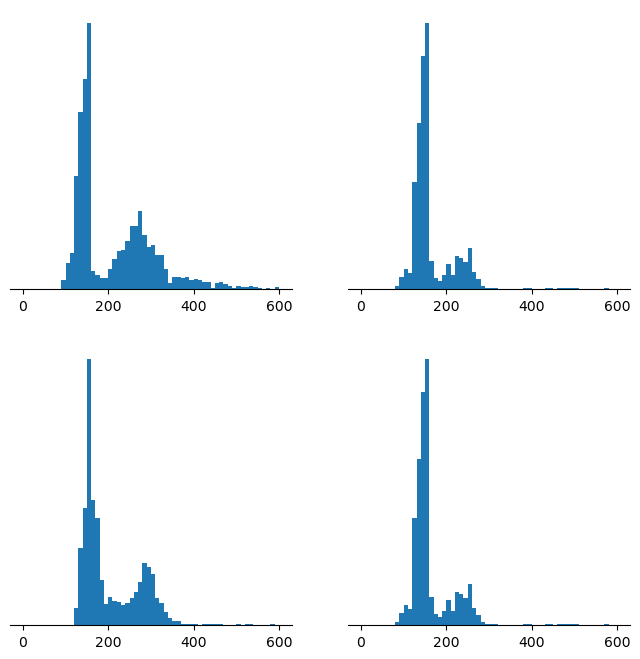

In [23]:
# summarize RT behavior for each subject

don_s12_rt = all_bhv['rt'].loc[(all_bhv['fname'].str.contains('D')) & (all_bhv['state'] < 3) & (all_bhv['forced']== 0)]
don_s3_rt = all_bhv['rt'].loc[(all_bhv['fname'].str.contains('D')) & (all_bhv['state'] == 3) & (all_bhv['forced']== 0)]

king_s12_rt = all_bhv['rt'].loc[(all_bhv['fname'].str.contains('K')) & (all_bhv['state'] < 3) & (all_bhv['forced']== 0)]
king_s3_rt = all_bhv['rt'].loc[(all_bhv['fname'].str.contains('K')) & (all_bhv['state'] == 3) & (all_bhv['forced']== 0)]


# generate bins for the histogram
bins = generate_histogram_bins(0, 600, 10)

# plot
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Don, RTs in states 1 and 2
_ =ax[0, 0].hist(don_s12_rt, bins=bins, density=True)
ax[0, 0].yaxis.set_visible(False)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_visible(False)  

# Don, RTs in state 3
_ =ax[0, 1].hist(don_s3_rt, bins=bins, density=True)
ax[0, 1].yaxis.set_visible(False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)  

# King, RTs in states 1 and 2
_ =ax[1, 0].hist(king_s12_rt, bins=bins, density=True)
ax[1, 0].yaxis.set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_visible(False)  

# King, RTs in state 3
_ =ax[1, 1].hist(don_s3_rt, bins=bins, density=True)
ax[1, 1].yaxis.set_visible(False)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_visible(False)  




Text(0.5, 1.0, 'K CdN')

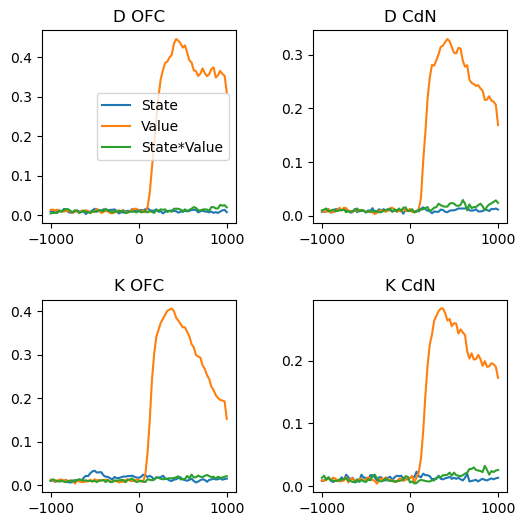

In [37]:
# create some indices for subject and brain area
ofc_ix = all_brain_area == 1
cdn_ix = all_brain_area == 0

d_ix = all_subj == 0
k_ix = all_subj == 1

fig, prop_ax = plt.subplots(2, 2, figsize=(6, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

prop_ax[0,0].plot(ts, np.mean(all_sliding_pvals[d_ix & ofc_ix,:,0] < .01, axis=0), label = 'State')
prop_ax[0,0].plot(ts, np.mean(all_sliding_pvals[d_ix & ofc_ix,:,1] < .01, axis=0), label = 'Value')
prop_ax[0,0].plot(ts, np.mean(all_sliding_pvals[d_ix & ofc_ix,:,2] < .01, axis=0), label = 'State*Value')
prop_ax[0,0].set_title('D OFC')
prop_ax[0,0].legend()

prop_ax[0,1].plot(ts, np.mean(all_sliding_pvals[d_ix & cdn_ix,:,0] < .01, axis=0))
prop_ax[0,1].plot(ts, np.mean(all_sliding_pvals[d_ix & cdn_ix,:,1] < .01, axis=0))
prop_ax[0,1].plot(ts, np.mean(all_sliding_pvals[d_ix & cdn_ix,:,2] < .01, axis=0))
prop_ax[0,1].set_title('D CdN')

prop_ax[1,0].plot(ts, np.mean(all_sliding_pvals[k_ix & ofc_ix,:,0] < .01, axis=0), label = 'State')
prop_ax[1,0].plot(ts, np.mean(all_sliding_pvals[k_ix & ofc_ix,:,1] < .01, axis=0), label = 'Value')
prop_ax[1,0].plot(ts, np.mean(all_sliding_pvals[k_ix & ofc_ix,:,2] < .01, axis=0), label = 'State*Value')
prop_ax[1,0].set_title('K OFC')

prop_ax[1,1].plot(ts, np.mean(all_sliding_pvals[k_ix & cdn_ix,:,0] < .01, axis=0))
prop_ax[1,1].plot(ts, np.mean(all_sliding_pvals[k_ix & cdn_ix,:,1] < .01, axis=0))
prop_ax[1,1].plot(ts, np.mean(all_sliding_pvals[k_ix & cdn_ix,:,2] < .01, axis=0))
prop_ax[1,1].set_title('K CdN')


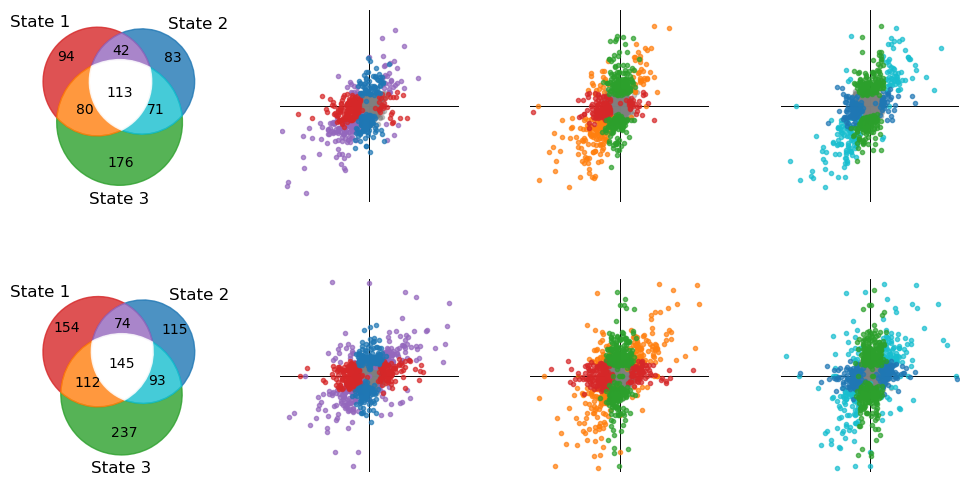

In [24]:
# scatter plot the value betas for each neuron in each state

# OFC

# create some indices for subject and brain area
area_ix = all_brain_area == 1 # 1= ofc, 0 = caudate
d_ix = all_subj == 0
k_ix = all_subj == 1

# Determine significant neurons
sig_units = all_choice_pvals < .01

# Extract beta weights for the three states
betas1 = all_choice_betas[:, 0]
betas2 = all_choice_betas[:, 1]
betas3 = all_choice_betas[:, 2]

# Determine significance for each state
sig1 = sig_units[:, 0]
sig2 = sig_units[:, 1]
sig3 = sig_units[:, 2]
ax_range = (-.4, .4)

# Windsorize values to the range of the plot
betas1[np.abs(betas1) > np.max(ax_range)] = 0
betas2[np.abs(betas2) > np.max(ax_range)] = 0
betas3[np.abs(betas3) > np.max(ax_range)] = 0

fig, scat_ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

scat_ax[0,1].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,1].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,1].scatter(betas1[~sig1 & ~sig2 & d_ix & area_ix], betas2[~sig1 & ~sig2 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,1].scatter(betas1[sig1 & sig2 & d_ix & area_ix], betas2[sig1 & sig2 & d_ix & area_ix], color='tab:purple', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].scatter(betas1[sig1 & ~sig2 & d_ix & area_ix], betas2[sig1 & ~sig2 & d_ix  & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].scatter(betas1[~sig1 & sig2 & d_ix & area_ix], betas2[~sig1 & sig2 & d_ix  & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].set_xlim(ax_range)
scat_ax[0,1].set_ylim(ax_range)
scat_ax[0,1].spines['top'].set_visible(False)
scat_ax[0,1].spines['bottom'].set_visible(False)
scat_ax[0,1].spines['right'].set_visible(False)
scat_ax[0,1].spines['left'].set_visible(False)  
scat_ax[0,1].yaxis.set_visible(False)
scat_ax[0,1].xaxis.set_visible(False)


scat_ax[0,2].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,2].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,2].scatter(betas1[~sig1 & ~sig3 & d_ix & area_ix], betas3[~sig1 & ~sig3 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,2].scatter(betas1[sig1 & sig3 & d_ix & area_ix], betas3[sig1 & sig3 & d_ix & area_ix], color='tab:orange', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].scatter(betas1[sig1 & ~sig3 & d_ix & area_ix], betas3[sig1 & ~sig3 & d_ix & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].scatter(betas1[~sig1 & sig3 & d_ix & area_ix], betas3[~sig1 & sig3 & d_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].set_xlim(ax_range)
scat_ax[0,2].set_ylim(ax_range)
scat_ax[0,2].spines['top'].set_visible(False)
scat_ax[0,2].spines['bottom'].set_visible(False)
scat_ax[0,2].spines['right'].set_visible(False)
scat_ax[0,2].spines['left'].set_visible(False)  
scat_ax[0,2].yaxis.set_visible(False)
scat_ax[0,2].xaxis.set_visible(False)


scat_ax[0,3].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,3].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,3].scatter(betas2[~sig2 & ~sig3 & d_ix & area_ix], betas3[~sig2 & ~sig3 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,3].scatter(betas2[sig2 & sig3 & d_ix & area_ix], betas3[sig2 & sig3 & d_ix & area_ix], color='tab:cyan', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].scatter(betas2[sig2 & ~sig3 & d_ix & area_ix], betas3[sig2 & ~sig3 & d_ix & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].scatter(betas2[~sig2 & sig3 & d_ix & area_ix], betas3[~sig2 & sig3 & d_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].set_xlim(ax_range)
scat_ax[0,3].set_ylim(ax_range)
scat_ax[0,3].spines['top'].set_visible(False)
scat_ax[0,3].spines['bottom'].set_visible(False)
scat_ax[0,3].spines['right'].set_visible(False)
scat_ax[0,3].spines['left'].set_visible(False)  
scat_ax[0,3].yaxis.set_visible(False)
scat_ax[0,3].xaxis.set_visible(False)

# Create sets of significant neurons for each task state
d_set1 = set(np.where(sig_units[d_ix & area_ix, 0])[0])
d_set2 = set(np.where(sig_units[d_ix & area_ix, 1])[0])
d_set3 = set(np.where(sig_units[d_ix & area_ix, 2])[0])
# Plot Venn diagram
d_venn = venn3([d_set1, d_set2, d_set3], ('State 1', 'State 2', 'State 3'), ax=scat_ax[0,0])
# Define colors for each set
colors = {'100': 'tab:red', '010': 'tab:blue', '001': 'tab:green',
          '110': 'tab:purple', '101': 'tab:orange', '011': 'tab:cyan', '111': 'white'}

# Apply colors to the regions
for region_id, color in colors.items():
    d_venn.get_patch_by_id(region_id).set_color(color)
    d_venn.get_patch_by_id(region_id).set_alpha(0.8)  # Optional: set transparency


scat_ax[1,1].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,1].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,1].scatter(betas1[~sig1 & ~sig2 & k_ix & area_ix], betas2[~sig1 & ~sig2 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,1].scatter(betas1[sig1 & sig2 & k_ix & area_ix], betas2[sig1 & sig2 & k_ix & area_ix], color='tab:purple', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].scatter(betas1[sig1 & ~sig2 & k_ix & area_ix], betas2[sig1 & ~sig2 & k_ix  & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].scatter(betas1[~sig1 & sig2 & k_ix & area_ix], betas2[~sig1 & sig2 & k_ix  & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].set_xlim(ax_range)
scat_ax[1,1].set_ylim(ax_range)
scat_ax[1,1].spines['top'].set_visible(False)
scat_ax[1,1].spines['bottom'].set_visible(False)
scat_ax[1,1].spines['right'].set_visible(False)
scat_ax[1,1].spines['left'].set_visible(False)  
scat_ax[1,1].yaxis.set_visible(False)
scat_ax[1,1].xaxis.set_visible(False)


scat_ax[1,2].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,2].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,2].scatter(betas1[~sig1 & ~sig3 & k_ix & area_ix], betas3[~sig1 & ~sig3 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,2].scatter(betas1[sig1 & sig3 & k_ix & area_ix], betas3[sig1 & sig3 & k_ix & area_ix], color='tab:orange', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].scatter(betas1[sig1 & ~sig3 & k_ix & area_ix], betas3[sig1 & ~sig3 & k_ix & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].scatter(betas1[~sig1 & sig3 & k_ix & area_ix], betas3[~sig1 & sig3 & k_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].set_xlim(ax_range)
scat_ax[1,2].set_ylim(ax_range)
scat_ax[1,2].spines['top'].set_visible(False)
scat_ax[1,2].spines['bottom'].set_visible(False)
scat_ax[1,2].spines['right'].set_visible(False)
scat_ax[1,2].spines['left'].set_visible(False)  
scat_ax[1,2].yaxis.set_visible(False)
scat_ax[1,2].xaxis.set_visible(False)


scat_ax[1,3].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,3].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,3].scatter(betas2[~sig2 & ~sig3 & k_ix & area_ix], betas3[~sig2 & ~sig3 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,3].scatter(betas2[sig2 & sig3 & k_ix & area_ix], betas3[sig2 & sig3 & k_ix & area_ix], color='tab:cyan', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].scatter(betas2[sig2 & ~sig3 & k_ix & area_ix], betas3[sig2 & ~sig3 & k_ix & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].scatter(betas2[~sig2 & sig3 & k_ix & area_ix], betas3[~sig2 & sig3 & k_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].set_xlim(ax_range)
scat_ax[1,3].set_ylim(ax_range)
scat_ax[1,3].spines['top'].set_visible(False)
scat_ax[1,3].spines['bottom'].set_visible(False)
scat_ax[1,3].spines['right'].set_visible(False)
scat_ax[1,3].spines['left'].set_visible(False)  
scat_ax[1,3].yaxis.set_visible(False)
scat_ax[1,3].xaxis.set_visible(False)

# Create sets of significant neurons for each task state
k_set1 = set(np.where(sig_units[k_ix & area_ix, 0])[0])
k_set2 = set(np.where(sig_units[k_ix & area_ix, 1])[0])
k_set3 = set(np.where(sig_units[k_ix & area_ix, 2])[0])
# Plot Venn diagram
k_venn = venn3([k_set1, k_set2, k_set3], ('State 1', 'State 2', 'State 3'), ax=scat_ax[1,0])
# Define colors for each set
colors = {'100': 'tab:red', '010': 'tab:blue', '001': 'tab:green',
          '110': 'tab:purple', '101': 'tab:orange', '011': 'tab:cyan', '111': 'white'}

# Apply colors to the regions
for region_id, color in colors.items():
    k_venn.get_patch_by_id(region_id).set_color(color)
    k_venn.get_patch_by_id(region_id).set_alpha(0.8)  # Optional: set transparency



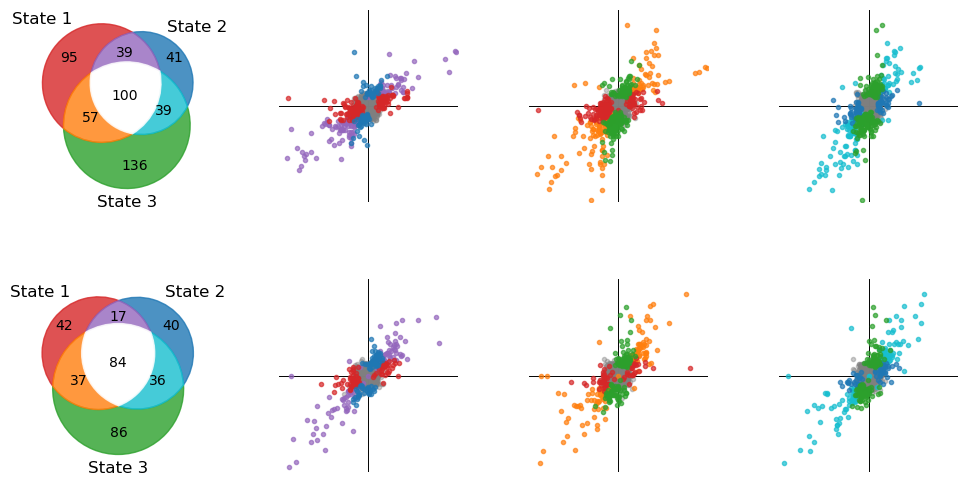

In [38]:
# Caudate

# create some indices for subject and brain area
area_ix = all_brain_area == 0 # 1= ofc, 0 = caudate
d_ix = all_subj == 0
k_ix = all_subj == 1

# Determine significant neurons
sig_units = all_choice_pvals < .01

# Extract beta weights for the three states
betas1 = all_choice_betas[:, 0]
betas2 = all_choice_betas[:, 1]
betas3 = all_choice_betas[:, 2]

# Determine significance for each state
sig1 = sig_units[:, 0]
sig2 = sig_units[:, 1]
sig3 = sig_units[:, 2]
ax_range = (-.4, .4)

# Windsorize values to the range of the plot
betas1[np.abs(betas1) > np.max(ax_range)] = 0
betas2[np.abs(betas2) > np.max(ax_range)] = 0
betas3[np.abs(betas3) > np.max(ax_range)] = 0

fig, scat_ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

scat_ax[0,1].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,1].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,1].scatter(betas1[~sig1 & ~sig2 & d_ix & area_ix], betas2[~sig1 & ~sig2 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,1].scatter(betas1[sig1 & sig2 & d_ix & area_ix], betas2[sig1 & sig2 & d_ix & area_ix], color='tab:purple', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].scatter(betas1[sig1 & ~sig2 & d_ix & area_ix], betas2[sig1 & ~sig2 & d_ix  & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].scatter(betas1[~sig1 & sig2 & d_ix & area_ix], betas2[~sig1 & sig2 & d_ix  & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[0,1].set_xlim(ax_range)
scat_ax[0,1].set_ylim(ax_range)
scat_ax[0,1].spines['top'].set_visible(False)
scat_ax[0,1].spines['bottom'].set_visible(False)
scat_ax[0,1].spines['right'].set_visible(False)
scat_ax[0,1].spines['left'].set_visible(False)  
scat_ax[0,1].yaxis.set_visible(False)
scat_ax[0,1].xaxis.set_visible(False)


scat_ax[0,2].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,2].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,2].scatter(betas1[~sig1 & ~sig3 & d_ix & area_ix], betas3[~sig1 & ~sig3 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,2].scatter(betas1[sig1 & sig3 & d_ix & area_ix], betas3[sig1 & sig3 & d_ix & area_ix], color='tab:orange', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].scatter(betas1[sig1 & ~sig3 & d_ix & area_ix], betas3[sig1 & ~sig3 & d_ix & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].scatter(betas1[~sig1 & sig3 & d_ix & area_ix], betas3[~sig1 & sig3 & d_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[0,2].set_xlim(ax_range)
scat_ax[0,2].set_ylim(ax_range)
scat_ax[0,2].spines['top'].set_visible(False)
scat_ax[0,2].spines['bottom'].set_visible(False)
scat_ax[0,2].spines['right'].set_visible(False)
scat_ax[0,2].spines['left'].set_visible(False)  
scat_ax[0,2].yaxis.set_visible(False)
scat_ax[0,2].xaxis.set_visible(False)


scat_ax[0,3].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[0,3].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[0,3].scatter(betas2[~sig2 & ~sig3 & d_ix & area_ix], betas3[~sig2 & ~sig3 & d_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[0,3].scatter(betas2[sig2 & sig3 & d_ix & area_ix], betas3[sig2 & sig3 & d_ix & area_ix], color='tab:cyan', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].scatter(betas2[sig2 & ~sig3 & d_ix & area_ix], betas3[sig2 & ~sig3 & d_ix & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].scatter(betas2[~sig2 & sig3 & d_ix & area_ix], betas3[~sig2 & sig3 & d_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[0,3].set_xlim(ax_range)
scat_ax[0,3].set_ylim(ax_range)
scat_ax[0,3].spines['top'].set_visible(False)
scat_ax[0,3].spines['bottom'].set_visible(False)
scat_ax[0,3].spines['right'].set_visible(False)
scat_ax[0,3].spines['left'].set_visible(False)  
scat_ax[0,3].yaxis.set_visible(False)
scat_ax[0,3].xaxis.set_visible(False)

# Create sets of significant neurons for each task state
d_set1 = set(np.where(sig_units[d_ix & area_ix, 0])[0])
d_set2 = set(np.where(sig_units[d_ix & area_ix, 1])[0])
d_set3 = set(np.where(sig_units[d_ix & area_ix, 2])[0])
# Plot Venn diagram
d_venn = venn3([d_set1, d_set2, d_set3], ('State 1', 'State 2', 'State 3'), ax=scat_ax[0,0])
# Define colors for each set
colors = {'100': 'tab:red', '010': 'tab:blue', '001': 'tab:green',
          '110': 'tab:purple', '101': 'tab:orange', '011': 'tab:cyan', '111': 'white'}

# Apply colors to the regions
for region_id, color in colors.items():
    d_venn.get_patch_by_id(region_id).set_color(color)
    d_venn.get_patch_by_id(region_id).set_alpha(0.8)  # Optional: set transparency


scat_ax[1,1].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,1].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,1].scatter(betas1[~sig1 & ~sig2 & k_ix & area_ix], betas2[~sig1 & ~sig2 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,1].scatter(betas1[sig1 & sig2 & k_ix & area_ix], betas2[sig1 & sig2 & k_ix & area_ix], color='tab:purple', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].scatter(betas1[sig1 & ~sig2 & k_ix & area_ix], betas2[sig1 & ~sig2 & k_ix  & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].scatter(betas1[~sig1 & sig2 & k_ix & area_ix], betas2[~sig1 & sig2 & k_ix  & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[1,1].set_xlim(ax_range)
scat_ax[1,1].set_ylim(ax_range)
scat_ax[1,1].spines['top'].set_visible(False)
scat_ax[1,1].spines['bottom'].set_visible(False)
scat_ax[1,1].spines['right'].set_visible(False)
scat_ax[1,1].spines['left'].set_visible(False)  
scat_ax[1,1].yaxis.set_visible(False)
scat_ax[1,1].xaxis.set_visible(False)


scat_ax[1,2].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,2].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,2].scatter(betas1[~sig1 & ~sig3 & k_ix & area_ix], betas3[~sig1 & ~sig3 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,2].scatter(betas1[sig1 & sig3 & k_ix & area_ix], betas3[sig1 & sig3 & k_ix & area_ix], color='tab:orange', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].scatter(betas1[sig1 & ~sig3 & k_ix & area_ix], betas3[sig1 & ~sig3 & k_ix & area_ix], color='tab:red', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].scatter(betas1[~sig1 & sig3 & k_ix & area_ix], betas3[~sig1 & sig3 & k_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[1,2].set_xlim(ax_range)
scat_ax[1,2].set_ylim(ax_range)
scat_ax[1,2].spines['top'].set_visible(False)
scat_ax[1,2].spines['bottom'].set_visible(False)
scat_ax[1,2].spines['right'].set_visible(False)
scat_ax[1,2].spines['left'].set_visible(False)  
scat_ax[1,2].yaxis.set_visible(False)
scat_ax[1,2].xaxis.set_visible(False)


scat_ax[1,3].plot([0, 0], ax_range, color='k', zorder=1, linewidth = .7)
scat_ax[1,3].plot(ax_range, [0, 0], color='k', zorder=1, linewidth = .7)
scat_ax[1,3].scatter(betas2[~sig2 & ~sig3 & k_ix & area_ix], betas3[~sig2 & ~sig3 & k_ix & area_ix], color='tab:gray', zorder=2, alpha=.4, marker='.')
scat_ax[1,3].scatter(betas2[sig2 & sig3 & k_ix & area_ix], betas3[sig2 & sig3 & k_ix & area_ix], color='tab:cyan', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].scatter(betas2[sig2 & ~sig3 & k_ix & area_ix], betas3[sig2 & ~sig3 & k_ix & area_ix], color='tab:blue', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].scatter(betas2[~sig2 & sig3 & k_ix & area_ix], betas3[~sig2 & sig3 & k_ix & area_ix], color='tab:green', zorder=2, alpha=.7, marker='.')
scat_ax[1,3].set_xlim(ax_range)
scat_ax[1,3].set_ylim(ax_range)
scat_ax[1,3].spines['top'].set_visible(False)
scat_ax[1,3].spines['bottom'].set_visible(False)
scat_ax[1,3].spines['right'].set_visible(False)
scat_ax[1,3].spines['left'].set_visible(False)  
scat_ax[1,3].yaxis.set_visible(False)
scat_ax[1,3].xaxis.set_visible(False)

# Create sets of significant neurons for each task state
k_set1 = set(np.where(sig_units[k_ix & area_ix, 0])[0])
k_set2 = set(np.where(sig_units[k_ix & area_ix, 1])[0])
k_set3 = set(np.where(sig_units[k_ix & area_ix, 2])[0])
# Plot Venn diagram
k_venn = venn3([k_set1, k_set2, k_set3], ('State 1', 'State 2', 'State 3'), ax=scat_ax[1,0])
# Define colors for each set
colors = {'100': 'tab:red', '010': 'tab:blue', '001': 'tab:green',
          '110': 'tab:purple', '101': 'tab:orange', '011': 'tab:cyan', '111': 'white'}

# Apply colors to the regions
for region_id, color in colors.items():
    k_venn.get_patch_by_id(region_id).set_color(color)
    k_venn.get_patch_by_id(region_id).set_alpha(0.8)  # Optional: set transparency

In [ ]:
# Total number of neurons in area_ix
n = np.sum(ofc_ix)

# Determine which neurons pass each significance test
sig_units = p_vals[ofc_ix, :] < .01

# Bootstrap parameters
n_bootstraps = 10000  # Number of bootstrap samples
n_tests = p_vals.shape[1]  # Number of tests
bootstrap_diffs = np.zeros((n_bootstraps, n_tests, n_tests))  # Array to store bootstrap differences
observed_diffs = np.zeros((n_tests, n_tests))  # Array to store observed differences
p_values = np.zeros((n_tests, n_tests))  # Array to store p-values

# Calculate observed differences in proportions for each pair of tests
for i in range(n_tests):
    for j in range(i + 1, n_tests):
        # Determine neurons passing exactly one or both of the two tests
        sig1 = np.sum(sig_units[:, [i, j]], axis=1) == 1  # Passing exactly one test
        sig2 = np.sum(sig_units[:, [i, j]], axis=1) == 2  # Passing both tests

        # Calculate observed counts and proportions
        count_sig1 = np.sum(sig1)
        count_sig2 = np.sum(sig2)
        prop_sig1 = count_sig1 / n
        prop_sig2 = count_sig2 / n

        # Calculate the observed difference in proportions
        observed_diff = prop_sig1 - prop_sig2
        observed_diffs[i, j] = observed_diff

        # Bootstrap sampling to generate null distribution
        for k in range(n_bootstraps):
            # Generate random p-values to simulate the null distribution
            null_p_vals = np.random.rand(n, 2)
            null_sig_units = null_p_vals < .01  # Determine significance based on random p-values
            null_sig1 = np.sum(null_sig_units, axis=1) == 1  # Passing exactly one test
            null_sig2 = np.sum(null_sig_units, axis=1) == 2  # Passing both tests

            # Calculate counts and proportions for the bootstrap sample
            count_null_sig1 = np.sum(null_sig1)
            count_null_sig2 = np.sum(null_sig2)
            prop_null_sig1 = count_null_sig1 / n
            prop_null_sig2 = count_null_sig2 / n

            # Store the difference in proportions for the bootstrap sample
            bootstrap_diffs[k, i, j] = prop_null_sig1 - prop_null_sig2

        # Calculate p-value for the observed difference
        p_values[i, j] = np.sum(np.abs(bootstrap_diffs[:, i, j]) >= np.abs(observed_diff)) / n_bootstraps

# Print the results
for i in range(n_tests):
    for j in range(i + 1, n_tests):
        print(f"Pairwise comparison between test {i + 1} and test {j + 1}:")
        print(f"Observed difference in proportions: {observed_diffs[i, j]}")
        print(f"p-value: {p_values[i, j]}")


# Create sets of significant neurons for each task state
set1 = set(np.where(sig_units[:, 0])[0])
set2 = set(np.where(sig_units[:, 1])[0])
set3 = set(np.where(sig_units[:, 2])[0])

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn3([set1, set2, set3], ('Task State 1', 'Task State 2', 'Task State 3'))
plt.title('Overlap of Active Neurons Across Task States')
plt.show()

In [ ]:
# Determine significant neurons
sig_units = p_vals[ofc_ix, :] < .01

# Extract beta weights for the three states
betas1 = betas[ofc_ix, 0]
betas2 = betas[ofc_ix, 1]
betas3 = betas[ofc_ix, 2]

# Determine significance for each state
sig1 = sig_units[:, 0]
sig2 = sig_units[:, 1]
sig3 = sig_units[:, 2]
axis_range = [-.5, .5]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ax1.plot([0, 0], [-.3, .3], color='k', zorder=1)
ax1.plot([-.3, .3], [0, 0], color='k', zorder=1)
ax1.scatter(betas1[~sig1 & ~sig2], betas2[~sig1 & ~sig2], color='tab:gray', zorder=2, alpha=.4)
ax1.scatter(betas1[sig1 & sig2], betas2[sig1 & sig2], color='tab:purple', zorder=2, alpha=.7)
ax1.scatter(betas1[sig1 & ~sig2], betas2[sig1 & ~sig2], color='tab:red', zorder=2, alpha=.7)
ax1.scatter(betas1[~sig1 & sig2], betas2[~sig1 & sig2], color='tab:blue', zorder=2, alpha=.7)
ax1.set_xlim((-.3, .3))
ax1.set_ylim((-.3, .3))


ax2.plot([0, 0], [-.3, .3], color='k', zorder=1)
ax2.plot([-.3, .3], [0, 0], color='k', zorder=1)
ax2.scatter(betas1[~sig1 & ~sig3], betas3[~sig1 & ~sig3], color='tab:gray', zorder=2, alpha=.4)
ax2.scatter(betas1[sig1 & sig3], betas3[sig1 & sig3], color='tab:orange', zorder=2, alpha=.7)
ax2.scatter(betas1[sig1 & ~sig3], betas3[sig1 & ~sig3], color='tab:red', zorder=2, alpha=.7)
ax2.scatter(betas1[~sig1 & sig3], betas3[~sig1 & sig3], color='tab:green', zorder=2, alpha=.7)
ax2.set_xlim((-.3, .3))
ax2.set_ylim((-.3, .3))


ax3.plot([0, 0], [-.3, .3], color='k', zorder=1)
ax3.plot([-.3, .3], [0, 0], color='k', zorder=1)
ax3.scatter(betas2[~sig2 & ~sig3], betas3[~sig2 & ~sig3], color='tab:gray', zorder=2, alpha=.4)
ax3.scatter(betas2[sig2 & sig3], betas3[sig2 & sig3], color='tab:cyan', zorder=2, alpha=.7)
ax3.scatter(betas2[sig2 & ~sig3], betas3[sig2 & ~sig3], color='tab:blue', zorder=2, alpha=.7)
ax3.scatter(betas2[~sig2 & sig3], betas3[~sig2 & sig3], color='tab:green', zorder=2, alpha=.7)
ax3.set_xlim((-.3, .3))
ax3.set_ylim((-.3, .3))






The goal is to look at the value code during saccades 
- is the value associated with the first saccade of a single-saccade trial congruent with the state?
- is the value associated with the first saccade of a two-saccade trial incongruent with the state?

In [ ]:
# how much time do we want before and after each saccade?
offset = 400 #ms
n_samples4offset = int(offset / np.mean(np.diff(ts)))
n_samples_total = (2*n_samples4offset) + 1

# initialize arrays for regression coefficients and p_vals

# currently fixated option within the current state
sacc1_fix_beta_current = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after
sacc1_fix_pval_current = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after

# currently fixated option but with value from the alternative state
sacc1_fix_beta_alt = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after
sacc1_fix_pval_alt = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after

# non-fixated option with value from the current state
sacc1_other_beta_current = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after
sacc1_other_pval_current = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after

# non-fixated option with value from the alternative state
sacc1_other_beta_alt = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after
sacc1_other_pval_alt = np.zeros(shape=(n_units, n_samples_total)) # get offset ms before and after

sacc2_fr = np.zeros(shape=(n_units, 2*n_samples4offset)) # get offset ms before and after

# get the indices (in terms of ts) of when the first and second saccdes were
sacc1_ts_ix = np.abs(bhv['sacc1_t'].values[:, np.newaxis] - ts).argmin(axis=1)
sacc2_ts_ix = np.abs(bhv['sacc2_t'].values[:, np.newaxis] - ts).argmin(axis=1)

In [ ]:
# loop over neurons and do the regressions

# create some useful indices
sacc1_trials = (bhv['n_sacc'] == 1) & (bhv['rt'] < 600)
state12_trials = bhv['state'] < 3
free_trials = bhv['forced'] == 0

# extract the behavior to be used
sacc1_bhv = bhv.loc[sacc1_trials & state12_trials & free_trials]
sacc1_fr = firing_rates[sacc1_trials & state12_trials & free_trials,:,:]
f_sacc1_ts_ix = sacc1_ts_ix[sacc1_trials & state12_trials & free_trials]

n_sacc1_trials = np.shape(sacc1_fr)[0]


# create regressors
fixated_val_current_state = sacc1_bhv['sacc1_val'].astype(int).values 

fixated_val_current_state[fixated_val_current_state == 1] = -2
fixated_val_current_state[fixated_val_current_state == 2] = -1
fixated_val_current_state[fixated_val_current_state == 3] =  1
fixated_val_current_state[fixated_val_current_state == 4] =  2

fixated_val_alt_state = fixated_val_current_state*-1

# Ensure both arrays are 2D
fixated_val_current_state = fixated_val_current_state.reshape(-1, 1)
fixated_val_alt_state = fixated_val_alt_state.reshape(-1, 1)

# Concatenate horizontally
val_factor = np.concatenate((fixated_val_current_state, fixated_val_alt_state), axis=1)
val_factor = sm.add_constant(val_factor)

fixated_val_current_state = sm.add_constant(fixated_val_current_state)
fixated_val_alt_state = sm.add_constant(fixated_val_alt_state)

# loop over each neuron
for u in tqdm(range(n_units)):
    
    # pull this unit's firing rates
    u_fr = sacc1_fr[:,:,u]
    
    # initialize an array for this unit's saccade-aligned firing
    u_sacc1 = np.zeros(shape=(n_sacc1_trials, n_samples_total))
    
    # loop over the trials and assemble an array of firing rates aligned to the saccade onset
    for t in range(n_sacc1_trials):
        
        u_sacc1[t,:] = u_fr[t, f_sacc1_ts_ix[t] - n_samples4offset : f_sacc1_ts_ix[t] + n_samples4offset+1]
        
    # loop over the timesteps and regress
    for timestep in range(n_samples_total):
        
        # # fit regressions
        # fix_c_mdl = sm.OLS(u_sacc1[:,timestep], fixated_val_current_state).fit()
        # fix_alt_mdl = sm.OLS(u_sacc1[:,timestep], fixated_val_alt_state).fit()
        
        # sacc1_fix_beta_current[u,timestep] = fix_c_mdl.params[1]
        # sacc1_fix_pval_current[u,timestep] = fix_c_mdl.pvalues[1]
            
        # sacc1_fix_beta_alt[u,timestep] = fix_alt_mdl.params[1]
        # sacc1_fix_pval_alt[u,timestep] = fix_alt_mdl.pvalues[1]
        
        
        mdl = sm.OLS(u_sacc1[:,timestep], val_factor).fit()

        # Extract beta weights (coefficients) and p-values
        sacc1_fix_beta_current[u,timestep] = mdl.params[1]
        sacc1_fix_pval_current[u,timestep] = mdl.pvalues[1]
            
        sacc1_fix_beta_alt[u,timestep] = mdl.params[2]
        sacc1_fix_pval_alt[u,timestep] = mdl.pvalues[2]
                

    

In [ ]:
xt = np.arange(0, np.mean(np.diff(ts))*n_samples_total, np.mean(np.diff(ts))) - (np.mean(np.diff(ts))*n_samples_total)/2

plt.plot(xt, np.mean((sacc1_fix_pval_current[ofc_ix,:] < .01), axis=0))
plt.plot(xt, np.mean((sacc1_fix_pval_alt[ofc_ix,:] < .01), axis=0))